In [1]:
import os
import numpy as np

def load_all_updates(data_dirs):
    updates = []
    for run_dir in data_dirs:
        run_dir = "./dagmm/dagmm/dagmm_train_data/" + run_dir
        for fname in os.listdir(run_dir):
            if fname.endswith(".npy"):
                path = os.path.join(run_dir, fname)
                update = np.load(path)
                updates.append(update)
    return np.stack(updates)

dataset = "mnist"
train_dirs = [dataset + "/run_" + str(x) for x in range(1,15)]
X_train = load_all_updates(train_dirs)

test_dir = [dataset + "/run_test_" + str(x) for x in range(1,3)]
X_test = load_all_updates(test_dir)

print("Training samples:\n", X_train[0], '\t', "std: ", np.std(X_train[0]), '\n', X_train[1000], '\t', "std: ", np.std(X_train[1000]), '\n', X_train[-1], '\t', "std: ", np.std(X_train[-1]))
print("\nTest samples:\n", X_test[0], '\t', "std: ", np.std(X_train[0]), '\n', X_test[1000], '\t', "std: ", np.std(X_train[1000]), '\n', X_test[-1], '\t', "std: ", np.std(X_train[-1]))

input_dim = X_train.shape[1]
print("Input dim: ", input_dim)
print("Number of training data: ", len(X_train))
print("Number of validation data: ", len(X_test))

import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=False)

Training samples:
 [-0.1542326   0.02852689  0.1844252  ... -0.0286619   0.05342649
 -0.0031181 ] 	 std:  0.057875067 
 [-0.05867351  0.17474414  0.20249419 ...  0.05445097  0.02090178
  0.03732899] 	 std:  0.052149262 
 [ 0.07795206 -0.01389939  0.03749248 ...  0.04813148 -0.00778339
 -0.00448485] 	 std:  0.042552333

Test samples:
 [-0.00510249 -0.16541158 -0.1996275  ... -0.03856351 -0.08525728
 -0.06713521] 	 std:  0.057875067 
 [-0.13950148  0.16045414 -0.23551606 ... -0.01379922 -0.07255504
  0.01300576] 	 std:  0.052149262 
 [-0.14041911  0.15433095 -0.24030511 ... -0.01202868 -0.07550421
  0.01654903] 	 std:  0.042552333
Input dim:  61706
Number of training data:  8424
Number of validation data:  2200


In [4]:
np.random.seed(42)
def generate_random_samples(like_array, R=1e-3):
    return np.random.uniform(low=-R, high=R, size=like_array.shape)

def generate_random_data(like_array, R_values):
    random_data = []
    for R_value in R_values:
        random_data.append(generate_random_samples(like_array, R_value))
    return random_data

# Generate random samples (same shape as test set)
random_data = generate_random_data(X_test, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e1])
print("Random data used:")
for r in random_data:
    print(f"{r[0][:5]}", "std: ", np.std(r[0]))

Random data used:
[-0.02509198  0.09014286  0.04639879  0.0197317  -0.06879627] std:  0.05764499789388101
[-0.00627753 -0.00980954  0.00209561 -0.00923988  0.00655945] std:  0.0057666150975977165
[ 1.93710729e-04  4.71097054e-04 -1.60344618e-05  3.02352024e-04
 -8.74176061e-05] std:  0.0005771727417166974
[-2.43556233e-06  3.50967281e-05  8.45129394e-05  6.86783983e-05
 -4.19048076e-05] std:  5.7692581102258275e-05
[9.29233882e-06 3.81264334e-06 8.37214303e-06 4.78828820e-07
 2.18669571e-06] std:  5.7593604231439655e-06
[-5.71382055e-07  4.20631769e-07  7.31907355e-07  9.01971784e-08
  2.39476010e-07] std:  5.775114003234179e-07
[-4.71965765  8.27744873 -4.49644445 -1.25033423  8.55194807] std:  5.782869591188744


In [3]:
# Function to retrieve a list of energies of random data
def get_random_energies(random_data, dagmm_model, gmm_params):
    energy_list = []
    for data in random_data:
        data_loader = DataLoader(TensorDataset(torch.tensor(data, dtype=torch.float32)),
                                batch_size=batch_size, shuffle=False)
        energies = dagmm_model.compute_energies(data_loader, gmm_params)
        energy_list.append(energies)
    return energy_list

In [4]:
def train_dagmm(model, train_loader, num_epochs, lr=1e-3, lambda_energy=0.1, lambda_cov=0.005, device='cuda', print_info=True):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    i = 1
    for epoch in range(num_epochs):
        loss_info =  {
            "value": 0.0,
            "reconst": 0.0,
            "energy": 0.0,
            "cov_diag": 0.0,
        }

        for batch in train_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()

            loss, loss_dict = model.compute_loss(inputs, lambda_energy, lambda_cov)
            
            # Update weights
            loss.backward()
            optimizer.step()

            # record objective function
            loss_info["value"] += loss.item()
            loss_info["reconst"] += loss_dict["reconst"]
            loss_info["energy"] += loss_dict["energy"]
            loss_info["cov_diag"] += loss_dict["cov_diag"]

        loss_epoch = loss_info["value"] / len(train_loader)
        reconst_epoch = loss_info["reconst"] / len(train_loader)
        energy_epoch = lambda_energy * loss_info["energy"] / len(train_loader)
        cov_epoch = lambda_cov * loss_info["cov_diag"]/ len(train_loader)

        if (i <= 5 or i % 10 == 0) and print_info:
            print(
                    f"Epoch {epoch + 1}/{num_epochs}: \t\t"
                    + f"loss={loss_epoch:.6f} \t\t"
                    + f"reconst={reconst_epoch:.6f} "
                    + f"energy={energy_epoch:.6f} "
                    + f"cov_diag={cov_epoch:.6f}"
                )
        i += 1    

In [5]:
def eval_dagmm_model(dagmm_model, gmm_params):
    dagmm_model.eval()
    test_energies = dagmm_model.compute_energies(test_loader, gmm_params)
    mean_test_energy = np.mean(test_energies)

    random_energies_list = get_random_energies(random_data, dagmm_model, gmm_params)
    random_energies_lower_percentiles = []
    for random_energies in random_energies_list:
        # Get the 20th percentile of the random energies.
        random_energies_lower_percentiles.append(np.percentile(random_energies, 20))

    # Objective function of the grid search
    random_test_diffs = []
    for random_percentile in random_energies_lower_percentiles:
        random_test_diffs.append(random_percentile - mean_test_energy)

    # Use the percentile with the smallest energy. If this is higher than the mean energy of the test data, it is separable.
    min_rand_test_diff = np.min(random_test_diffs)
    return min_rand_test_diff

Hyperparameter Grid Search
---

In [6]:
from dagmm.dagmm.dagmm import DAGMM_Hyperparameters

from dagmm.std_dagmm.std_dagmm import STD_DAGMM
# Fixed Model settings
dimensions = [input_dim, 256, 128, 64]
latent_dim = 16
estimation_hidden_size = 14

# Fixed Training settings
lambda_energy=0.1
lambda_cov=0.01

# 1. Set seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

epoch_params = [15]
n_gmm_params = [10]

print_info = True   # Whether or not to print the losses.

# Initialize with 0 - anything smaller will indicate a bad separation of test and random data.
best_score = 0
best_model = None
best_hyperparameters = None
best_gmm_params = None

for epoch_p in epoch_params:
    for n_gmm_p in n_gmm_params:
        parameters = {
            "epoch": epoch_p,
            "n_gmm": n_gmm_p
        }
        print(f"Using parameters:\t epoch={epoch_p}, n_gmm={n_gmm_p}")

        # Generate DAGMM_Hyperparameters
        hyperparameters = DAGMM_Hyperparameters(dimensions, latent_dim, estimation_hidden_size, n_gmm_p)

        # --- Train the model ---
        dagmm_model = STD_DAGMM(device, hyperparameters)
        train_dagmm(dagmm_model, train_loader, epoch_p, lambda_energy=lambda_energy, lambda_cov=lambda_cov, print_info=print_info)
        dagmm_model.eval()

        # Obtain gmm parameters
        gmm_params = dagmm_model.compute_gmm_params(train_loader)
        
        # --- Evaluate the model ---        
        # The difference between training and test data should be small (not that important, thus we ommit it)
        # and the energy value (lower x'th percentile) of the (closest) random data should be bigger than the mean energy of the test data (very important to be able to separate)
        # A negative score indicates that the random data could not be separated well from the test data.
        # A positive score indicates that the separation works (the higher the score, the better the separation!)
        score = eval_dagmm_model(dagmm_model, gmm_params)
        print(f"Obtained score: {score}")

        if score > best_score:
            best_score = score
            best_model = dagmm_model
            best_hyperparameters = hyperparameters
            best_gmm_params = gmm_params
            print(f"\t\t!!! New best model found !!!")

Using parameters:	 epoch=15, n_gmm=10
Epoch 1/15: 		loss=70694.830448 		reconst=0.008891 energy=1.404150 cov_diag=70693.417407
Epoch 2/15: 		loss=4644.428687 		reconst=0.019830 energy=1.446823 cov_diag=4642.962034
Epoch 3/15: 		loss=5149.265924 		reconst=0.026611 energy=1.449821 cov_diag=5147.789491
Epoch 4/15: 		loss=4544.358539 		reconst=0.030238 energy=1.447390 cov_diag=4542.880912
Epoch 5/15: 		loss=4504.283581 		reconst=0.031868 energy=1.445019 cov_diag=4502.806694
Epoch 10/15: 		loss=4313.646910 		reconst=0.033173 energy=1.423867 cov_diag=4312.189870
Obtained score: 7.8871117230441605
		!!! New best model found !!!


In [18]:
# Save everything
torch.save(best_model.state_dict(), "./dagmm/std_dagmm/dagmm_model_mnist.pt")

for name, gmm_param in best_gmm_params.items():
    gmm_name = "./dagmm/std_dagmm/gmm_param_" + name + ".pt"
    torch.save(gmm_param, gmm_name)

# Store hyperparameters as a .yaml file
best_hyperparameters.save_params("./dagmm/std_dagmm/dagmm_hyperparameters.yaml")

Testing
===

In [19]:
from dagmm.dagmm.dagmm import DAGMM_Hyperparameters
from dagmm.std_dagmm.std_dagmm import STD_DAGMM
import torch
hyperparameters = DAGMM_Hyperparameters.load_params("./dagmm/std_dagmm/dagmm_hyperparameters.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dagmm_model = STD_DAGMM(device, hyperparameters)
dagmm_model.load_state_dict(torch.load("./dagmm/std_dagmm/dagmm_model_mnist.pt", map_location=device))
dagmm_model.to(device)

STD_DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=61706, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Tanh()
    (5): Linear(in_features=256, out_features=61706, bias=True)
  )
  (estimation): Sequential(
    (0): Linear(in_features=19, out_features=14, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=14, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [22]:
gmm_params = {}
gmm_params["mixture"] = torch.load("./dagmm/std_dagmm/gmm_param_mixture.pt")
gmm_params["mean"] = torch.load("./dagmm/std_dagmm/gmm_param_mean.pt")
gmm_params["cov"] = torch.load("./dagmm/std_dagmm/gmm_param_cov.pt")

In [23]:
train_energies = dagmm_model.compute_energies(train_loader, gmm_params)
test_energies = dagmm_model.compute_energies(test_loader, gmm_params)
print("Mean of train energies: ", np.mean(train_energies))
print("Mean of test energies: ", np.mean(test_energies))

Mean of train energies:  24.186167479463265
Mean of test energies:  26.71374687025474


In [24]:
random_energies = get_random_energies(random_data, dagmm_model, gmm_params)

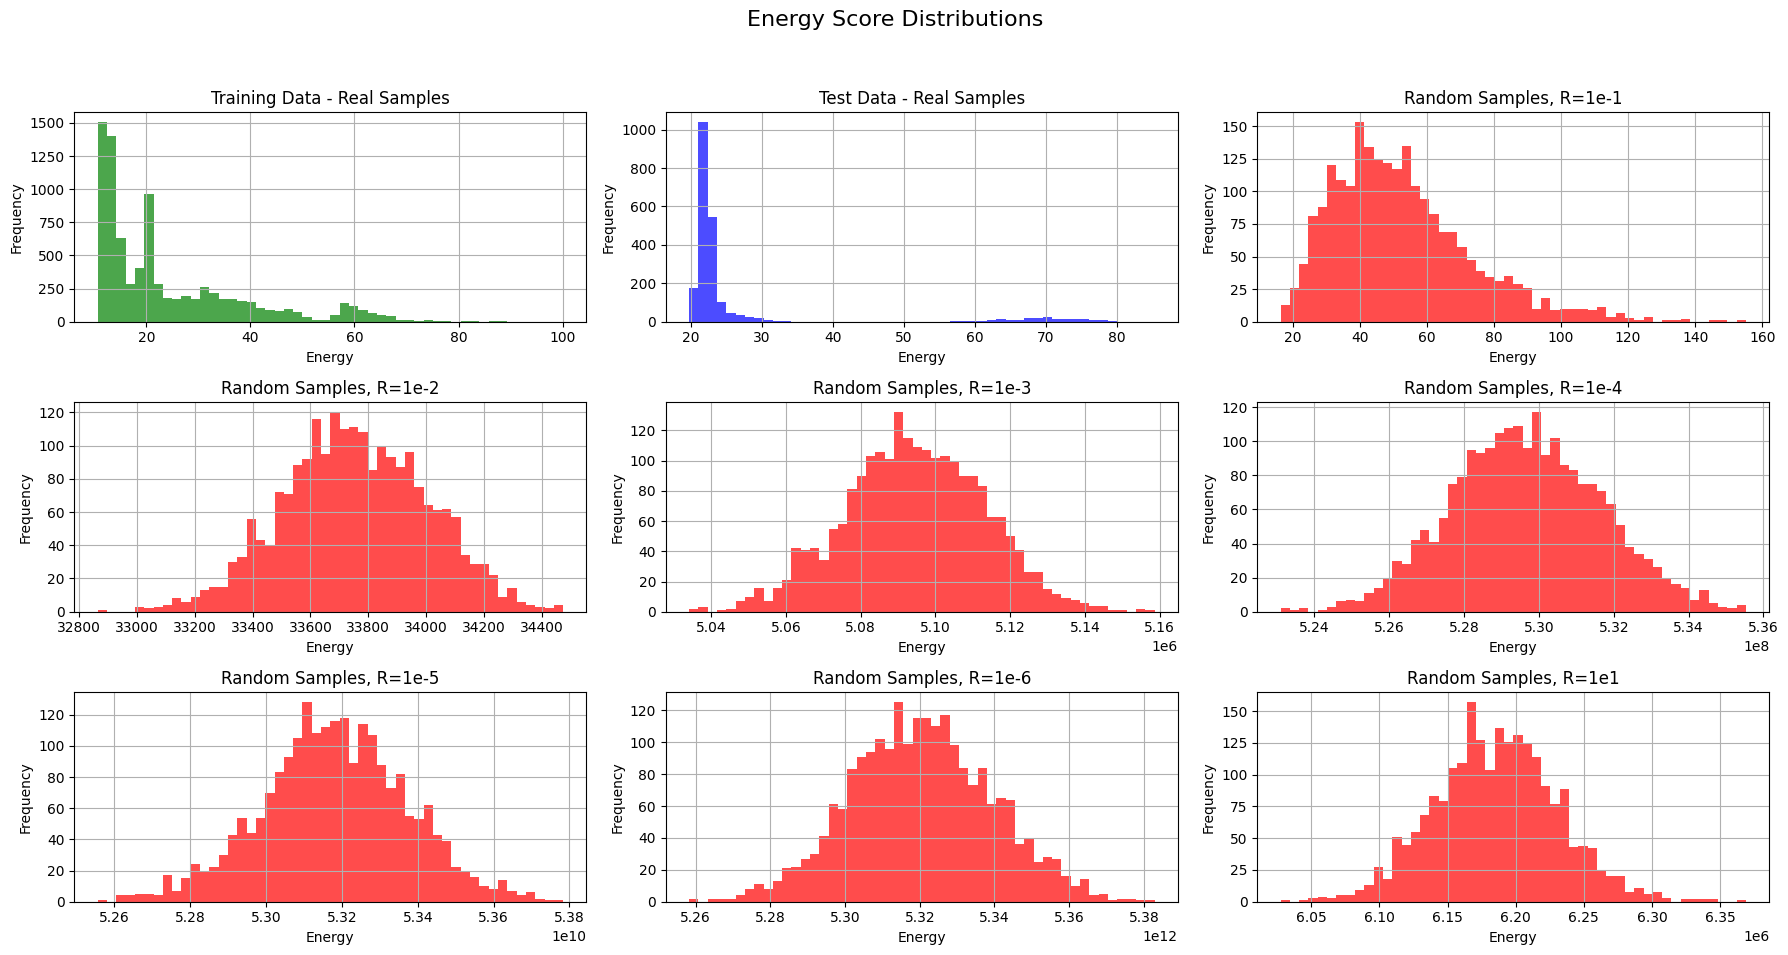

In [25]:
import matplotlib.pyplot as plt
# Plotting
# Plotting separate histograms
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle("Energy Score Distributions", fontsize=16)

# Plot 1: 
axes[0, 0].hist(train_energies, bins=50, alpha=0.7, color='green')
axes[0, 0].set_title("Training Data - Real Samples")
axes[0, 0].set_xlabel("Energy")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True)

# Plot 2: 
axes[0, 1].hist(test_energies, bins=50, alpha=0.7, color='blue')
axes[0, 1].set_title("Test Data - Real Samples")
axes[0, 1].set_xlabel("Energy")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True)

# Plot 3: 
axes[0, 2].hist(random_energies[0], bins=50, alpha=0.7, color='red')
axes[0, 2].set_title("Random Samples, R=1e-1")
axes[0, 2].set_xlabel("Energy")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].grid(True)

# Plot 4: 
axes[1, 0].hist(random_energies[1], bins=50, alpha=0.7, color='red')
axes[1, 0].set_title("Random Samples, R=1e-2")
axes[1, 0].set_xlabel("Energy")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True)

# Plot 5: 
axes[1, 1].hist(random_energies[2], bins=50, alpha=0.7, color='red')
axes[1, 1].set_title("Random Samples, R=1e-3")
axes[1, 1].set_xlabel("Energy")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True)

# Plot 6: 
axes[1, 2].hist(random_energies[3], bins=50, alpha=0.7, color='red')
axes[1, 2].set_title("Random Samples, R=1e-4")
axes[1, 2].set_xlabel("Energy")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].grid(True)

# Plot 7: 
axes[2, 0].hist(random_energies[4], bins=50, alpha=0.7, color='red')
axes[2, 0].set_title("Random Samples, R=1e-5")
axes[2, 0].set_xlabel("Energy")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].grid(True)

# Plot 8: 
axes[2, 1].hist(random_energies[5], bins=50, alpha=0.7, color='red')
axes[2, 1].set_title("Random Samples, R=1e-6")
axes[2, 1].set_xlabel("Energy")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True)

# Plot 9: 
axes[2, 2].hist(random_energies[6], bins=50, alpha=0.7, color='red')
axes[2, 2].set_title("Random Samples, R=1e1")
axes[2, 2].set_xlabel("Energy")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].grid(True)
#axes[2, 2].set_xlim(-5, 5) # Adjust based on data

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [26]:
percentile = 90
threshold_percentile = np.percentile(test_energies, percentile)
print(f"{percentile} percentile is: {threshold_percentile:.4f}")
factor = 2
threshold = threshold_percentile * factor

print(f"\nAnomaly Threshold (at {factor} * {percentile}th percentile of all energies): {threshold:.4f}")
print("Maximum energy: ", max(test_energies))

90 percentile is: 29.9569

Anomaly Threshold (at 2 * 90th percentile of all energies): 59.9138
Maximum energy:  85.29526680703697


In [14]:
import yaml
threshold_dict = {
    'dagmm_threshold': float(threshold)
}

output_yaml_path = './dagmm/std_dagmm/dagmm_anomaly_threshold.yaml'
with open(output_yaml_path, 'w') as file:
    yaml.dump(threshold_dict, file, default_flow_style=False)

print(f"Anomaly threshold saved to '{output_yaml_path}'")

Anomaly threshold saved to './dagmm/std_dagmm/dagmm_anomaly_threshold.yaml'


In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def get_z_values(dataloader, dagmm_model):
    z_values = []
    for batch in dataloader:
        inputs = batch[0].to(device)

        _, latents, _ = dagmm_model.forward(inputs)
        z_values.append(latents)
    return torch.cat(z_values, dim=0).detach().cpu().numpy()

def pca_with_random_data(real_loaders, real_lables, random_data_list, dagmm_model):
    z_values_real = []
    for loader in real_loaders:
        z_values_real.append(get_z_values(loader, dagmm_model))

    labels = []
    z_values_random_list = []
    for i, rand_data in enumerate(random_data_list):
        random_dataloader = DataLoader(TensorDataset(torch.tensor(rand_data, dtype=torch.float32)),
                                batch_size=batch_size, shuffle=False)
        z = get_z_values(random_dataloader, dagmm_model)
        z_values_random_list.append(z)
        labels.append(f"Random_{i+1}")

    # Use PCA for 2D projection
    pca = PCA(n_components=2)
    z_real_2d = [pca.fit_transform(data) for data in z_values_real]
    z_random_2d = [pca.transform(data) for data in z_values_random_list]

    plt.figure(figsize=(8, 6))
    for data_2d, label in zip(z_real_2d, real_lables):
        sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], label=label, alpha=0.6)

    for i, data_2d in enumerate(z_random_2d):
        sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], label=labels[i], alpha=0.6)

    plt.title("PCA of Latent z-space")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

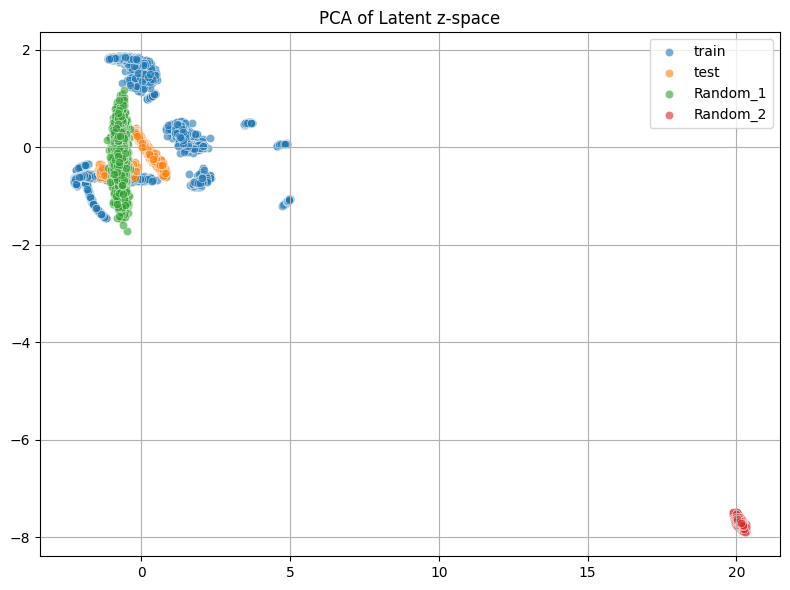

In [16]:
pca_with_random_data([train_loader, test_loader], ["train", "test"], random_data[:2], dagmm_model)

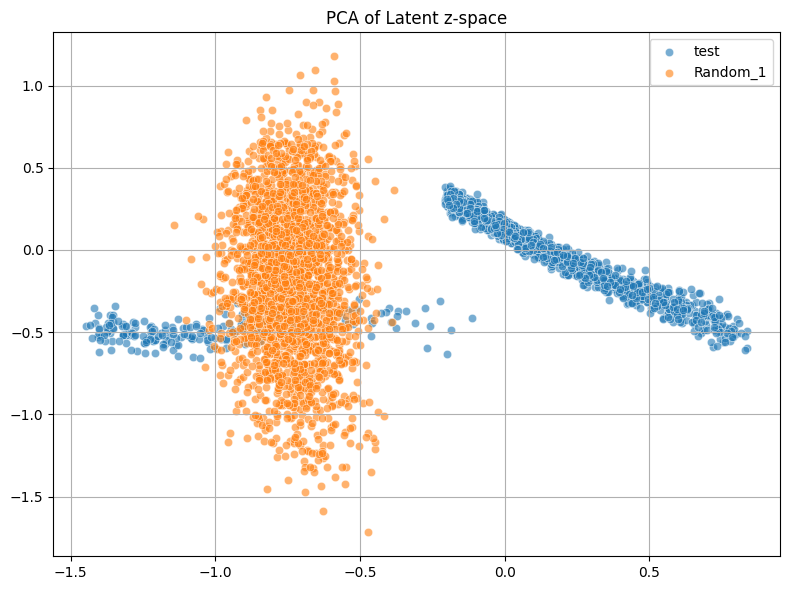

In [17]:
pca_with_random_data([test_loader], ["test"], [random_data[0]], dagmm_model)